# Predicting Loan Outcomes on Lending Club

***By Joe Corliss***

## Table of Contents

1. [Summary](#1)
    1. [Spoilers](#1.1)

# Introduction

[Dataset 1](https://www.kaggle.com/wordsforthewise/lending-club) - The dataset used in this project, hosted on Kaggle

[Dataset 2](https://www.kaggle.com/wendykan/lending-club-loan-data) - Another Lending Club dataset on Kaggle, not used in this project

[Kaggle notebook](https://www.kaggle.com/pileatedperch/predicting-loan-status-mcc-0-73) - This notebook on Kaggle

[Lending Club statistics](https://www.lendingclub.com/info/download-data.action) - Original data source

[GitHub repository](https://github.com/jgcorliss/lending-club) - This project on GitHub

[EXPAND INTRODUCTION] The goal of this project is to predict loan charge-offs only using data available at the time of the loan application.

# Import the Data
<a id="2"></a>

Package imports:

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

Read the data into a pandas dataframe.

In [2]:
loans = pd.read_csv('accepted_2007_to_2017Q3.csv.gz', compression='gzip')

C:\Users\Joe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,18,48,58,117,128,129,130,133,134,135,138,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Check basic dataframe info.

In [3]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646801 entries, 0 to 1646800
Columns: 150 entries, id to settlement_term
dtypes: float64(113), object(37)
memory usage: 1.8+ GB


Let's view the data from some randomly chosen loans:

In [4]:
loans.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1411287,96123461,NaN,2500.0,2500.0,2500.0,36 months,12.74,83.93,C,C1,Psychiatric Social Worker,< 1 year,RENT,85000.0,Source Verified,Dec-2016,Fully Paid,n,NaN,other,Other,926xx,CA,19.26,0.0,Feb-2000,675.0,679.0,0.0,48.0,NaN,8.0,0.0,20225.0,79.0,15.0,f,0.00,0.00,2765.270506,2765.27,2500.00,265.27,0.0,0.0,0.0,Dec-2017,1930.39,NaN,Dec-2017,649.0,645.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,118519.0,0.0,4.0,0.0,2.0,14.0,98294.0,52.0,1.0,2.0,12384.0,63.0,25600.0,0.0,1.0,0.0,4.0,14815.0,1735.0,91.5,0.0,0.0,147.0,202.0,10.0,10.0,0.0,10.0,NaN,NaN,NaN,0.0,2.0,3.0,2.0,3.0,7.0,4.0,8.0,3.0,8.0,0.0,0.0,0.0,1.0,92.3,100.0,0.0,0.0,126168.0,118519.0,20500.0,100568.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
215809,11665451,NaN,7000.0,7000.0,7000.0,36 months,8.90,222.28,A,A5,NaN,2 years,RENT,50995.0,Source Verified,Feb-2014,Fully Paid,n,Borrower added on 02/07/14 > I would like to consolidate several vendor credit accounts into a single account with a lower interest rate.<br>,debt_consolidation,Debt consolidation,958xx,CA,5.67,0.0,Aug-2000,715.0,719.0,0.0,NaN,39.0,10.0,1.0,3982.0,19.7,24.0,f,0.00,0.00,7829.900003,7829.90,7000.00,829.90,0.0,0.0,0.0,Nov-2015,3384.30,NaN,Dec-2017,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,15989.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20200.0,NaN,NaN,NaN,1.0,1599.0,431.0,76.1,0.0,0.0,162.0,66.0,23.0,23.0,0.0,43.0,NaN,NaN,NaN,0.0,1.0,3.0,1.0,6.0,13.0,6.0,11.0,3.0,10.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,1.0,31824.0,15989.0,1800.

# Response Variable
<a id="3"></a>

We're going to try to predict the `loan_status` column. What are the value counts in this column?

In [5]:
loans['loan_status'].value_counts(dropna=False)

Current                                                788950
Fully Paid                                             646902
Charged Off                                            168084
Late (31-120 days)                                      23763
In Grace Period                                         10474
Late (16-30 days)                                        5786
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    70
NaN                                                        23
Name: loan_status, dtype: int64

We're going to try to predict the final status of completed loans. More specifically, we'll only consider loans that meet the credit policy and have either been fully paid or charged off. These are the two cases we'll try to distinguish with a predictive model.

So we only retain the loans with `loan_status` "Fully Paid" or "Charged Off." The other loans either (i) have not been completed, with status "Current," "Late," or "In Grace Period"; (ii) do not meet the credit policy; or (iii) have defaulted, a case that we won't consider because these loans are extremely rare.

In [6]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]

How many loans remain in the dataset?

In [7]:
loans.shape

(814986, 150)

Check the status counts:

In [8]:
loans['loan_status'].value_counts(normalize=False, dropna=False) # Value counts as fractions of the total

Fully Paid     646902
Charged Off    168084
Name: loan_status, dtype: int64

In [9]:
loans['loan_status'].value_counts(normalize=True, dropna=False) # Value counts as fractions of the total

Fully Paid     0.793758
Charged Off    0.206242
Name: loan_status, dtype: float64

About 79% of the remaining loans have been fully paid and 21% have been charged off, leading to a somewhat unbalanced classification problem.

# Feature Selection
<a id="4"></a>

The dataset has 150 features, but we won't be using all the features to predict the loan status. We'll first drop any features that meet either of the following criteria:

1. More than 30% of the data is missing (in the training set)
2. The feature would not have been available at the time of the loan application

Definitions of the features are given in the Lending Club Data Dictionary [available here](https://www.lendingclub.com/info/download-data.action).

## Drop features missing too much data
<a id="4.2"></a>

First we calculate the percentage of missing data for each feature:

In [10]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False)

Let's visualize the distribution of missing data percentages:

Text(0,0.5,'Variable count')

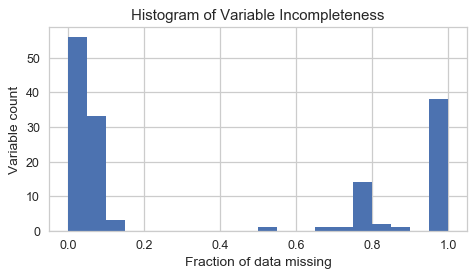

In [11]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Variable Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Variable count')

From the above histogram, we see there's a large gap between features missing "some" data and those missing "lots" of data. Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns. First store all variables missing more than 30% data in a list:

In [12]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

In [13]:
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

How many features will be dropped?

In [14]:
len(drop_list)

58

Now drop these features.

In [15]:
def drop_cols(cols):
    # cols can be a single string, or a list of strings
    loans.drop(labels=cols, axis=1, inplace=True)
    missing_fractions.drop(labels=cols, inplace=True)

In [16]:
drop_cols(drop_list)

## Remove features that were unavailable before the loan was funded
<a id="4.4"></a>

We examine the Lending Club Data Dictionary to determine which features would not have been available before the loan was funded. The idea here is to predict whether a loan will be paid off **before** deciding to fund the loan. Here's the list of features we currently have, in alphabetical order:

In [17]:
print(sorted(list(loans.columns)))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

For each of these features, we check the description in the Data Dictionary, and drop those features that we believe would not have been available before the loan was funded. When in doubt, we err on the side of dropping the feature.

In [18]:
drop_list = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 'revol_bal', 'revol_util', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim']

How many features will be dropped?

In [19]:
len(drop_list)

62

Drop these variables:

In [20]:
drop_cols(drop_list)

## Inspect the remaining features

We'll inspect each feature individually, and do the following:

1. View summary statistics and visualize the data, if desired.
2. Modify the feature to make it useful for modeling, if necessary.
3. Drop the feature if it can't be made useful for modeling.

In [82]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        fully_paid_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True)[:,'Fully Paid']
        sns.barplot(x=fully_paid_rates.index, y=fully_paid_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction Fully Paid')
        ax2.set_title('Fully Paid Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

How many features are left?

In [22]:
loans.shape[1]

30

What are the remaining features?

In [23]:
print(list(loans.columns))

['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'pub_rec', 'initial_list_status', 'policy_code', 'application_type', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc', 'pub_rec_bankruptcies', 'disbursement_method']


### id

Data Dictionary: "A unique [Lending Club] assigned ID for the loan listing."

In [24]:
loans['id'].sample(5)

1377133    77293623
115972     21110833
43025      32038131
259892       603488
1152573    85517837
Name: id, dtype: object

 Are all the IDs in fact unique?

In [25]:
loans['id'].describe()

count       814986
unique      814986
top       14680062
freq             1
Name: id, dtype: int64

Yes. The ID is most likely useless for predicting charge-offs, but we'll keep it for now.

### loan_amnt

Data Dictionary: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."

In [27]:
loans['loan_amnt'].describe()

count    814986.000000
mean      14315.458210
std        8499.799241
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       40000.000000
Name: loan_amnt, dtype: float64

Loan amounts range from \$500 to \$40,000, with a median of \$12,000.

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


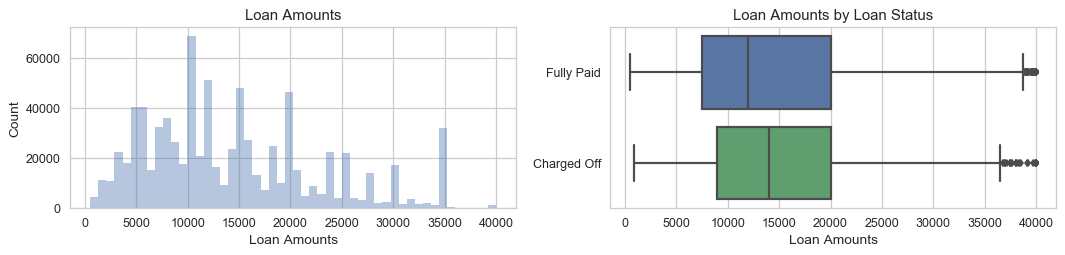

In [28]:
plot_var('loan_amnt', 'Loan Amounts', continuous=True)

Charged-off loans tend to have higher loan amounts. Because of the number of samples, the difference in the medians is statistically significant.

### term

Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."

Let's check the value counts:

In [29]:
loans['term'].value_counts(dropna=False)

 36 months    618460
 60 months    196526
Name: term, dtype: int64

Convert `term` to integers.

In [30]:
loans.loc[:,'term'] = loans['term'].apply(lambda s: np.int8(s.split()[0]))

In [31]:
loans['term'].value_counts(normalize=True)

36    0.75886
60    0.24114
Name: term, dtype: float64

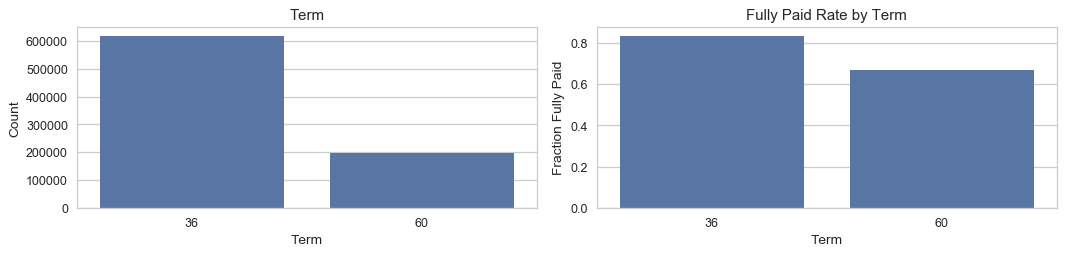

In [70]:
plot_var('term', 'Term', continuous=False)

About 76% of loans are 36 months, and the rest are 60 months. Loans with 60-month terms are less likely to be fully paid.

### int_rate

Data Dictionary: "Interest Rate on the loan."

In [34]:
loans['int_rate'].describe()

count    814986.000000
mean         13.490993
std           4.618486
min           5.320000
25%           9.990000
50%          13.110000
75%          16.290000
max          30.990000
Name: int_rate, dtype: float64

Interest rates range from 5.3% to 30.9% (!), with a median of 13.1%.

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


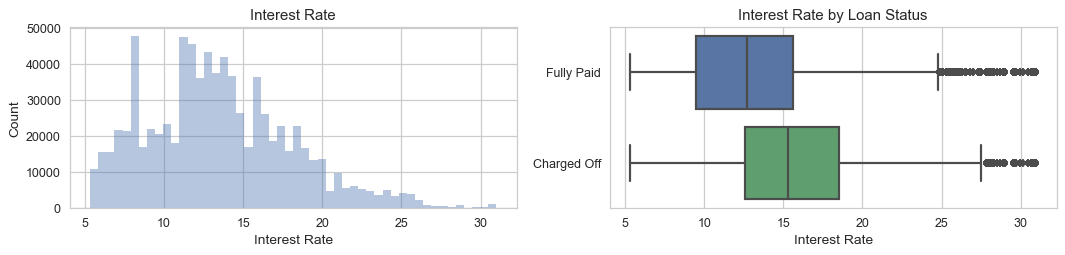

In [35]:
plot_var('int_rate', 'Interest Rate', continuous=True)

Charged-off loans tend to have higher interest rates.

### installment

Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

In [36]:
loans['installment'].describe()

count    814986.000000
mean        436.749624
std         255.732093
min           4.930000
25%         251.400000
50%         377.040000
75%         576.290000
max        1714.540000
Name: installment, dtype: float64

Installments range from \$4.93 to \$1,714, with a median of \$377.

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


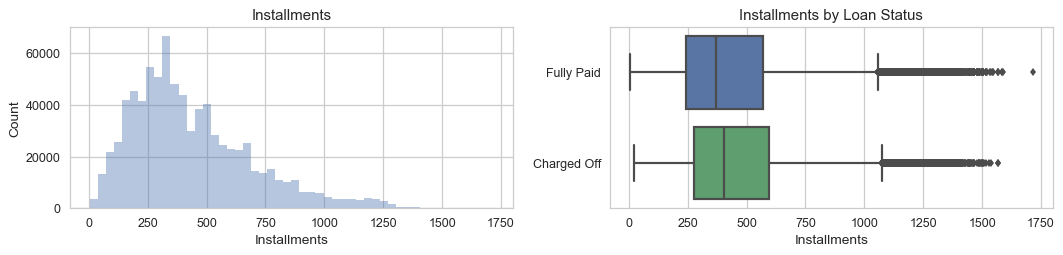

In [38]:
plot_var('installment', 'Installment', continuous=True)

Charged-off loans tend to have slightly higher installments.

### grade, sub_grade

Data Dictionary for `grade`: "[Lending Club] assigned loan grade."

Data Dictionary for `sub_grade`: "LC assigned loan subgrade."

What are the possible values of `grade` and `sub_grade`?

In [50]:
print(sorted(loans['grade'].unique()))

KeyError: 'grade'

In [63]:
print(sorted(loans['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The grade is implied by the subgrade, so let's drop the grade column.

In [44]:
drop_cols('grade')

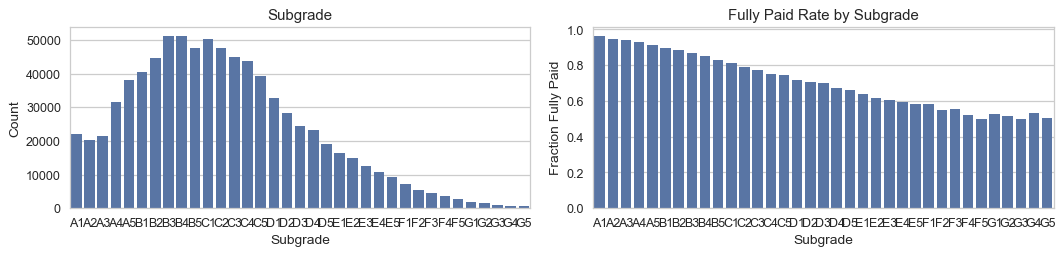

In [71]:
plot_var('sub_grade', 'Subgrade', continuous=False)

There's a clear trend of higher probability of charge-off as the subgrade worsens.

### emp_title

Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [72]:
loans['emp_title'].describe()

count      766415
unique     280473
top       Teacher
freq        11351
Name: emp_title, dtype: object

In [73]:
loans.shape[0]

814986

There are too many different job titles for this feature to be useful, so we drop it.

In [74]:
drop_cols('emp_title')

### emp_length

Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." The actual data does not match this description:

In [75]:
loans['emp_length'].value_counts(dropna=False).sort_index()

1 year        53411
10+ years    264873
2 years       73493
3 years       64999
4 years       48752
5 years       52149
6 years       40290
7 years       39407
8 years       38887
9 years       31900
< 1 year      64572
NaN           42253
Name: emp_length, dtype: int64

Note there are 42,253 loans without data on the length of employment.

Convert `emp_length` to integers:

In [76]:
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

In [77]:
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [78]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [79]:
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)

In [80]:
loans['emp_length'].value_counts(dropna=False).sort_index()

 0.0      64572
 1.0      53411
 2.0      73493
 3.0      64999
 4.0      48752
 5.0      52149
 6.0      40290
 7.0      39407
 8.0      38887
 9.0      31900
 10.0    264873
NaN       42253
Name: emp_length, dtype: int64

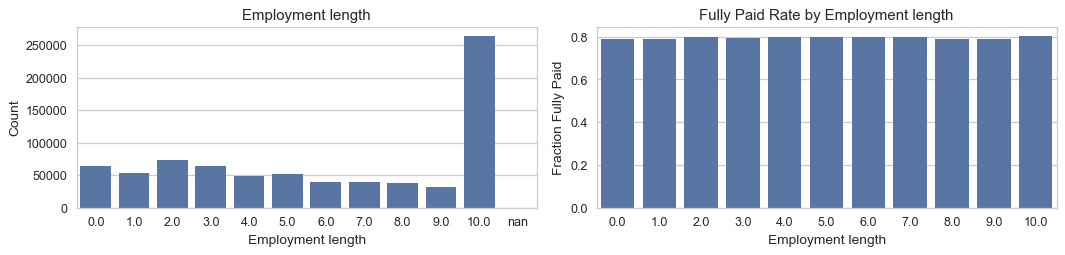

In [84]:
plot_var('emp_length', 'Employment length', continuous=False)

Loan status does not appear to depend at all on employment length, so we drop this variable.

In [85]:
drop_cols('emp_length')

### home_ownership

Data Dictionary: "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

In [87]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    406866
RENT        325071
OWN          82765
OTHER          144
ANY             94
NONE            46
Name: home_ownership, dtype: int64

Replace ANY and NONE with OTHER, so that we have enough observations of each category.

In [88]:
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [89]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    406866
RENT        325071
OWN          82765
OTHER          284
Name: home_ownership, dtype: int64

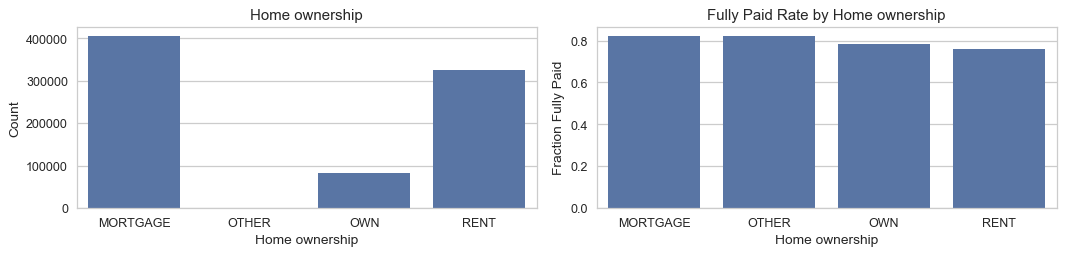

In [91]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

There appear to be small differences in charge-off rates by home ownership status. Renters have slightly less probability of fully paying off the loan. Because of the large numbers of observations in each category, these differences are statistically significant.

### annual_inc

Data Dictionary: "The self-reported annual income provided by the borrower during registration."

In [92]:
loans['annual_inc'].describe()

count    8.149860e+05
mean     7.523039e+04
std      6.524373e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.550000e+06
Name: annual_inc, dtype: float64

Annual income ranges from \$0 to \$9,550,000, with a median of \$65,000. (Note this is more than double the national individual median income in the US.)

Because of the large range of incomes, we should take a log transform.

In [103]:
loans['annual_inc'] = loans['annual_inc'].apply(lambda x: np.log(x+1))

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


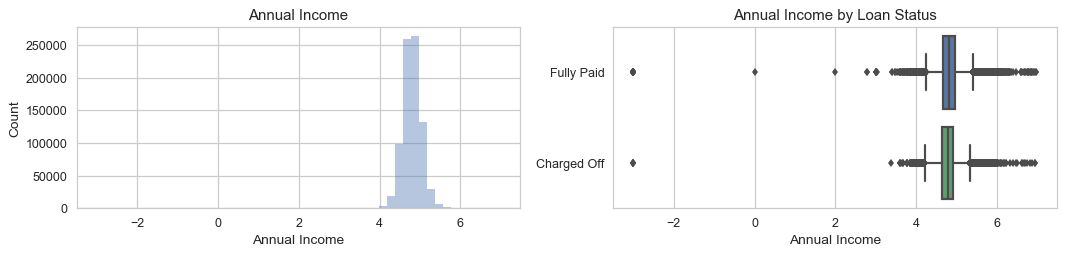

In [112]:
plot_var('annual_inc', 'Log Annual Income', continuous=True)

### verification_status

In [ ]:
df['verification_status'].value_counts()

### pymnt_plan

In [ ]:
df['pymnt_plan'].value_counts(dropna=False)

This feature will be removed automatically later.

### purpose

In [ ]:
df['purpose'].value_counts()

Let's make a count plot of the loan purpose, separated by the `charged_off` value.

In [ ]:
plt.figure(figsize=(12,6), dpi=100)
sns.countplot(y='purpose', hue='charged_off', data=df, orient='h')

It appears that most of the charge-offs come from loans for debt consolidation or to pay off credit cards.

### zip_code, addr_state

In [ ]:
df['zip_code'].nunique()

In [ ]:
df['addr_state'].nunique()

There are a lot of zip codes, so let's just retain the state column.

In [ ]:
df.drop(labels=['zip_code'], axis=1, inplace=True)

### initial_list_status

In [ ]:
df['initial_list_status'].value_counts()

I wasn't able to determine what the initial list status means.

### application_type

In [ ]:
df['application_type'].value_counts()

### hardship_flag

In [ ]:
df['hardship_flag'].value_counts()

This feature will be removed automatically later.

### disbursement_method

In [ ]:
df['disbursement_method'].value_counts()

# Train/Test Split

We'll make our predictions more realistic by performing the train/validation/test split based on the month that the loan was funded. That is, we'll use loans funded on earlier dates to predict the outcome of loans funded on later dates.

The variable `issue_d` includes the month which the loan was funded. Let's peek at this variable:

In [ ]:
loans['issue_d'].sample(5)

So `issue_d` only includes month and year data. Are there any missing values?

In [ ]:
loans['issue_d'].isnull().any()

No. Let's convert the issue dates to datetime objects:

In [ ]:
loans['issue_d'] = pd.to_datetime(loans['issue_d'])

In [ ]:
loans['issue_d'].sample(5)

The `issue_d` values got converted to dates, all on the first day of the month. Check summary statistics of the issue dates:

In [ ]:
loans['issue_d'].describe()

Note there are only 124 unique issue dates over the 10-year period because we only have month/year information. In this particular dataset, the first loans were issued in June 2007, and the most recent loans were issued in September 2017. The busiest month was October 2014 with 33,699 loans funded in that month. What is the distribution of loans among the years 2007-2017?

In [ ]:
plt.figure(figsize=(6,3), dpi=90)
loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of loans funded')
plt.title('Loans Funded per Year')

We'll form the test set from the most recent 10% of the loans, and the validation set from the next-most-recent 10%.

In [ ]:
loans_train = loans.loc[loans['issue_d'] <  loans['issue_d'].quantile(0.8)]
loans_valid = loans.loc[(loans['issue_d'] >= loans['issue_d'].quantile(0.8)) & (loans['issue_d'] < loans['issue_d'].quantile(0.9))]
loans_test =  loans.loc[loans['issue_d'] >= loans['issue_d'].quantile(0.9)]

Check that we properly partitioned the loans:

In [ ]:
print('Number of loans in the partition:   ', loans_train.shape[0] + loans_valid.shape[0] + loans_test.shape[0])
print('Number of loans in the full dataset:', loans.shape[0])

The partition looks good, so we can delete the original `loans` dataframe.

In [ ]:
del loans

Let's look at the summary statistics of the issue dates in the train/validation/test sets:

In [ ]:
loans_train['issue_d'].describe()

In [ ]:
loans_valid['issue_d'].describe()

In [ ]:
loans_test['issue_d'].describe()

The training set includes loans from June 2007 to December 2015. The validation set includes loans from January 2016 to June 2016. The test set includes loans from July 2016 to September 2017.

# Exploratory Data Analysis
<a id="5"></a>

Now let's compare the borrower's most recent FICO score (a credit score) to the loan status.

In [ ]:
plt.figure(figsize=(10,4), dpi=90)
sns.distplot(df['last_fico_range_high'].loc[df['charged_off']==0], label='charged_off = 0')
sns.distplot(df['last_fico_range_high'].loc[df['charged_off']==1], label='charged_off = 1')
plt.xlabel('last_fico_range_high')
plt.ylabel('density')
plt.legend()

There's a strong correlation here: charged-off loans tend to have much lower FICO scores.

# More Pre-processing
<a id="7"></a>

## Create dummy variables
<a id="6.1"></a>

In [ ]:
df.shape

In [ ]:
df = pd.get_dummies(df, drop_first=True)

In [ ]:
df.shape

Now all the features (171 of them) are numerical. What does the data look like after converting categorical features to dummy variables?

In [ ]:
df.sample(3)

## Train/test split
<a id="7.1"></a>

In [ ]:
X = df.drop(labels=['charged_off'], axis=1) # Features
y = df.loc[:,'charged_off'] # Response variable
df = None

In [ ]:
from sklearn.model_selection import train_test_split

Let's do a 90/10 train/test split.

In [ ]:
random_state = 1 # Just to make the results fixed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state, stratify=y)
X = None
y = None

In [ ]:
X_train.shape

In [ ]:
X_test.shape

## Imputation with mean substitution
<a id="7.2"></a>

How complete is our training data?

In [ ]:
incomplete_cols(X_train)

The learning algorithms cannot have missing data. Perform mean substitution, using only the means of the training set to prevent test set leakage.

In [ ]:
from sklearn.preprocessing import Imputer

In [ ]:
imputer = Imputer().fit(X_train)

In [ ]:
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(imputer.transform(X_test),  columns=X_test.columns)

## Standardize the data
<a id="7.3"></a>

Shift and scale each column individually so that it has zero mean and unit variance. This will help to train the linear models.

Train the scaler using only the training data to prevent test set leakage.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler().fit(X_train)

In [ ]:
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

## Automatic feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [ ]:
selector = SelectKBest(mutual_info_classif, k=15)

In [ ]:
selector.fit(X_train.iloc[1:50000], y_train.iloc[1:50000])

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
X_train = selector.transform(X_train)
X_test  = selector.transform(X_test)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

# Predictive Modeling: SGDClassifier
<a id="8"></a>

I decided to use a SGD Classifier by looking at the machine learning flowchart here: http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html.

The SGDClassifier estimator implements linear classifiers (SVM, logistic regression, a.o.) with SGD training. The linear classifier is chosen by the `loss` hyperparameter.

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef, make_scorer

## Train with grid search
<a id="8.1"></a>

We're going to search through many hyperparameters of SGDClassifier using an exhaustive grid search with 3-fold cross-validation, implemented in GridSearchCV.

Here are the hyperparameters that we'll try:

In [ ]:
param_grid = [{'loss': ['hinge'],
               'alpha': [10.0**k for k in range(-3, 3)],
               'class_weight': [None, 'balanced']},
              {'loss': ['log'],
               'alpha': [10.0**k for k in range(-3, 3)],
               'penalty': ['l2', 'l1']}]

Instantiate the grid estimator. We'll use the Matthews correlation coefficient as our scoring metric.

In [ ]:
grid = GridSearchCV(estimator=SGDClassifier(max_iter=1000, tol=1e-3, random_state=random_state, warm_start=True), param_grid=param_grid, scoring=make_scorer(matthews_corrcoef), n_jobs=4, pre_dispatch=8, cv=5, verbose=1)

Run the grid search (this could take some time).

In [ ]:
grid.fit(X_train, y_train)

Hyperparameters that gave the best results on the hold out data:

In [ ]:
grid.best_params_

Mean cross-validated MCC score of the best estimator:

In [ ]:
grid.best_score_

Weights assigned to the features by the best estimator:

In [ ]:
plt.figure(figsize=(6,4), dpi=90)
sns.barplot(y=np.arange(0,15), x=grid.best_estimator_.coef_[0,:], orient='h')
plt.title("Classifier Weights")
plt.xlabel("classifier weight")

## Test set evaluation
<a id="8.2"></a>

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score

In [ ]:
def classification_eval(estimator, X_test, y_test):
    """
    Print several metrics of classification performance of an estimator, given features X_test and true labels y_test.
    
    Input: estimator or GridSearchCV instance, X_test, y_test
    Returns: text printout of metrics
    """
    y_pred = estimator.predict(X_test)
    
    # Number of decimal places based on number of samples
    dec = np.int64(np.ceil(np.log10(len(y_test))))
    
    print('Confusion matrix')
    print(confusion_matrix(y_test, y_pred), '\n')
    
    print('Classification report')
    print(classification_report(y_test, y_pred, digits=dec))
    
    print('Scalar metrics')
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('MCC', matthews_corrcoef(y_test, y_pred)))
    if y_test.nunique() <= 2: # Additional metrics for binary classification
        try:
            y_score = estimator.predict_proba(X_test)[:,1]
        except:
            y_score = estimator.decision_function(X_test)
        print(format_str % ('AUPRC', average_precision_score(y_test, y_score)))
        print(format_str % ('AUROCC', roc_auc_score(y_test, y_score)))
    print(format_str % ("Cohen's kappa", cohen_kappa_score(y_test, y_pred)))
    print(format_str % ('Accuracy', accuracy_score(y_test, y_pred)))
    # Add Informedness
    # Add Markedness
    # Add Fleiss' kappa

Test set evaluation metrics:

In [ ]:
classification_eval(grid, X_test, y_test)